# Import libraries

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML preprocessing/optimizing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import shap


# Scoring
from sklearn.metrics import roc_auc_score

# Data formatting/preprocessing
import time 
import tqdm
import pickle
import numpy as np
import pandas as pd


# Ml models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

### Advanse optimizing (HyperOpt Parameter Tuning)
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

## Useful
#pd.set_option('display.max_columns', None)

%matplotlib inline 

# Reading data

In [2]:
with open('train_part1.pkl', 'rb') as f1:
    train_part1 = pickle.load(f1)

with open('train_part2.pkl', 'rb') as f2:
    train_part2 = pickle.load(f2)
    
with open('test_data.pkl', 'rb') as f3:
    test_data = pickle.load(f3)

## Distribution of target

In [3]:
train_part1.TARGET.value_counts()

0    732535
1     31266
Name: TARGET, dtype: int64

#### We can see class disbalance problem

### Get only numerical columns at first

In [4]:
df_numerics_only = train_part1.select_dtypes(include=np.number)
target = df_numerics_only.TARGET

df_numerics_only = df_numerics_only.apply(lambda x: x.fillna(x.mean()),axis=0)
cols = df_numerics_only.columns
l = []
for i in range(len(cols)):
    l.append(target.corr(df_numerics_only.loc[:,cols[i]]))

### Correlation between target and numerical features

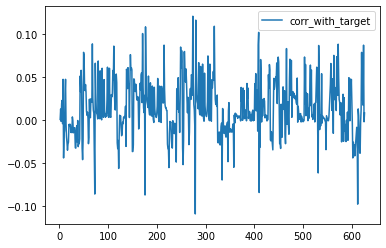

In [5]:
corr_data = pd.DataFrame([cols, l]).T.iloc[:628,:].dropna()
corr_data = corr_data.rename(columns={0:'feature', 1:'corr_with_target'})
corr_data['corr_with_target'] = pd.to_numeric(corr_data['corr_with_target'])
corr_data.plot();

### Get the most largest and smallest correlations and corresponding features

In [6]:
corr_data.nlargest(15, 'corr_with_target')

,feature,corr_with_target
274,x_286,0.121005
280,x_292,0.116459
318,x_330,0.109346
177,x_189,0.108632
409,x_421,0.102239
171,x_183,0.100842
68,x_80,0.088774
572,x_584,0.088426
408,x_420,0.087458
215,x_227,0.087346


In [7]:
corr_data.nsmallest(15, 'corr_with_target')

,feature,corr_with_target
279,x_291,-0.109343
612,x_630,-0.097946
176,x_188,-0.087319
73,x_85,-0.086197
410,x_422,-0.084399
334,x_346,-0.069840
531,x_543,-0.061604
122,x_134,-0.056354
225,x_237,-0.055390
358,x_370,-0.055001


#### The idea is that simple linear correlation can tell us what features have more significant linear dependence - these features from the first point of view are better and should be chosen

# Lets handle with non-numeric data

In [8]:
train_part1.select_dtypes(exclude=np.number).shape

(763801, 18)

#### There are only 18 columns that are non-numeric and shoud be preprocessed

In [9]:
train_part1.select_dtypes(exclude=np.number).columns

Index(['REPORT_DT', 'x_9', 'x_12', 'x_13', 'x_17', 'x_18', 'x_19', 'x_21',
       'x_25', 'x_26', 'x_27', 'x_614', 'x_615', 'x_617', 'x_618', 'x_625',
       'x_628', 'x_634'],
      dtype='object')

## Feature x_12 looks like credit rate

In [10]:
a = []
for i in train_part1.select_dtypes(exclude=np.number).x_12.unique():
    a.append(train_part1[train_part1['x_12'] == i].TARGET.mean())

res = pd.DataFrame([train_part1.select_dtypes(exclude=np.number).x_12.unique(), a])    
res.T.sort_values(by = 1)

,0,1
6,A1,0.019427
3,A,0.030718
0,B1,0.03394
5,B,0.042134
1,D,0.049258
4,C,0.050675
2,N,0.059137


#### Looks like our hypothesis is right

## For x_12 we will do a mapping - replace letters by mean values (it is a good idea because it has an order)

### x_18

In [11]:
train_part1.select_dtypes(exclude=np.number).x_18.value_counts()

Вт    149381
Ср    147631
Чт    142560
Пн    137282
Пт    131018
Сб     49719
Вс      6210
Name: x_18, dtype: int64

In [12]:
a = []
for i in train_part1.select_dtypes(exclude=np.number).x_18.unique():
    a.append(train_part1[train_part1['x_18'] == i].TARGET.mean())

res = pd.DataFrame([train_part1.select_dtypes(exclude=np.number).x_18.unique(), a])    
res.T.sort_values(by = 1)

,0,1
6,Вс,0.031562
5,Сб,0.035158
0,Пн,0.039736
1,Чт,0.040383
4,Вт,0.040936
3,Пт,0.04275
2,Ср,0.043311


#### Looks like weekends positively reflects on credibility

### x_19

In [13]:
def rating_mean(name):
    a = []
    for i in train_part1.select_dtypes(exclude=np.number)['{}'.format(name)].unique():
        a.append(train_part1[train_part1['{}'.format(name)] == i].TARGET.mean())

    res = pd.DataFrame([train_part1.select_dtypes(exclude=np.number)['{}'.format(name)].unique(), a])    
    res=res.T.sort_values(by = 1)
    return res

# Check how can we replace non-numeric labels by counting mean statistics

In [14]:
for i in train_part1.select_dtypes(exclude=np.number).columns:
    try:
        print('non numeric feature {}'.format(i))
        print(rating_mean(i))
        print("##############################################")
    except ValueError: 
        pass

non numeric feature REPORT_DT
             0         1
513 2017-04-07       0.0
813 2017-08-25       0.0
814 2018-09-14       0.0
815 2018-03-31       0.0
816 2019-01-12       0.0
..         ...       ...
13  2017-07-03  0.068541
440 2017-04-10  0.069372
749 2017-07-10  0.070243
286 2017-08-29  0.074457
657 2017-03-06  0.083333

[1028 rows x 2 columns]
##############################################
non numeric feature x_9
              0      1
1595 2015-01-06    0.0
690  2017-07-08    0.0
1663 2016-09-25    0.0
1662 2012-10-26    0.0
1661 2017-06-11    0.0
...         ...    ...
1644 2012-06-14  0.625
1636 2016-01-24    0.9
1834 2014-08-31    1.0
1869 2013-10-20    1.0
1872 2013-05-01    1.0

[1873 rows x 2 columns]
##############################################
non numeric feature x_12
    0         1
6  A1  0.019427
3   A  0.030718
0  B1   0.03394
5   B  0.042134
1   D  0.049258
4   C  0.050675
2   N  0.059137
##############################################
non numeric feature x_13
 

## drop due to non informativity: x_25, x_26, x_27, x_617 

In [15]:
train_part1.x_617.value_counts()

4     448421
1     270181
2      36367
5       8217
9        539
3         14
19        12
Name: x_617, dtype: int64

### x_617 = x_13 - if 1 then less probability to default than others

In [16]:
train_part1.x_13.value_counts()

4     448421
1     270181
2      36367
5       8217
9        539
3         14
19        12
Name: x_13, dtype: int64

#### observing results from above lets name perspectively_signif_non_num_features

In [17]:
perspectively_signif_non_num_features = ['x_12', 'x_13', 'x_18', 'x_19', 'x_21', 'x_614', 'x_615', 'x_625',
                                         'x_628', 'x_634']

## prepare them

### bineries

In [18]:
binaries = ['x_19', 'x_614', 'x_615', 'x_634']

In [19]:
train_part1[binaries] = train_part1[binaries].apply(pd.to_numeric)

### Very significant

#### 1) rating

In [20]:
mapping = rating_mean('x_12')

In [21]:
train_part1['x_12'].replace(mapping, inplace=True)

AttributeError: 'Series' object has no attribute '_replace_columnwise'

#### 2) day of week

In [ ]:
map_x_18 = rating_mean('x_18')
map_x_18

In [ ]:
not_weekend = train_part1[((train_part1['x_18'] != 'Вс') & (train_part1['x_18'] != 'Сб'))].TARGET.mean()
weekend = train_part1[((train_part1['x_18'] == 'Вс') | (train_part1['x_18'] == 'Сб'))].TARGET.mean()

In [ ]:
map_18 = {'Вс':weekend, 
         'Сб':weekend,
         'Пн':not_weekend,
         'Чт':not_weekend,
         'Вт':not_weekend,
         'Пт':not_weekend,
         'Ср':not_weekend}

In [ ]:
train_part1['x_18'].replace(map_18, inplace=True)

#### 3) x_13

In [ ]:
map_x_13 = rating_mean('x_13')
map_x_13

In [ ]:
not_1 = train_part1[train_part1['x_13'] != '1'].TARGET.mean()
map_13 = {'1':map_x_13.iloc[2,1], 
         '2':not_1,
         '3':not_1,
         '4':not_1,
         '5':not_1,
         '9':not_1,
         '19':not_1}

In [ ]:
train_part1['x_13'].replace(map_13, inplace=True)

## Target of credit (x_21)

In [ ]:
x_21 = rating_mean('x_21')

In [ ]:
map_21 = x_21.set_index(0).to_dict()[1]

In [ ]:
train_part1['x_21'].replace(map_21, inplace=True)

### Town or not (x_625)

In [ ]:
x_625 = rating_mean('x_625')
x_625

In [ ]:
map_625 = x_625.set_index(0).to_dict()[1]

In [ ]:
train_part1['x_625'].replace(map_625, inplace=True)

## Street or ЗП or сотрудник (628)

In [ ]:
x_628 = rating_mean('x_628')
x_628

In [ ]:
map_628 = x_628.set_index(0).to_dict()[1]
train_part1['x_628'].replace(map_628, inplace=True)

# All nun num - now numeric

In [ ]:
train_part1[perspectively_signif_non_num_features].info()

In [ ]:
train_part1.rename(columns={'x_12':'credit_rating', 'x_18':'day', 'x_21':'credit_purpose',
                            'x_625':'city', 'x_628':'street'}, inplace = True)

In [ ]:
train_part1.select_dtypes(exclude=object)

## Compare correlations of recently non numeric but very important features

In [ ]:
new_important = ['credit_rating', 'day', 'credit_purpose','city', 'street', 'x_13', 'x_19', 'x_614', 'x_615', 'x_634']

In [ ]:
train_part1[new_important].info()

In [ ]:
train_part1[new_important]

In [ ]:
train_part1 = train_part1.select_dtypes(include=[float, int])

In [ ]:
train_part1

In [ ]:
comapre_data = train_part1.apply(lambda x: x.fillna(x.mean()),axis=0)

In [ ]:
target = comapre_data.TARGET
m = []
cols = comapre_data.columns[:-2]
for i in range(len(cols)):
    m.append(target.corr(comapre_data.loc[:,cols[i]]))

In [ ]:
cols

In [ ]:

corr_data_1 = pd.DataFrame([cols, m]).T.iloc[:,:]
corr_data_1 = corr_data_1.rename(columns={0:'feature', 1:'corr_with_target'})
corr_data_1['corr_with_target'] = pd.to_numeric(corr_data_1['corr_with_target'])
corr_data_1.plot();

In [ ]:
corr_data_1.nlargest(45, 'corr_with_target')

In [ ]:
corr_data_1.nsmallest(15, 'corr_with_target')

In [ ]:
new_important.append('TARGET')

In [ ]:
comapre_data[new_important]

In [ ]:
target = comapre_data.TARGET
m = []
cols = comapre_data[new_important].columns
for i in range(len(cols)-1):
    m.append(target.corr(comapre_data.loc[:,cols[i]]))

In [ ]:
corr_data_2 = pd.DataFrame([cols, m]).T.iloc[:,:]
corr_data_2 = corr_data_2.rename(columns={0:'feature', 1:'corr_with_target'})
corr_data_2['corr_with_target'] = pd.to_numeric(corr_data_2['corr_with_target'])
corr_data_2.plot();

In [ ]:
corr_data_2.sort_values(by = 'corr_with_target', ascending = False)

In [ ]:
new_important = new_important[:-1]

# Regressors

In [ ]:
regressors = new_important + list(corr_data_1.nlargest(45, 'corr_with_target')['feature']) + list(corr_data_1.nsmallest(45, 'corr_with_target')['feature'])





In [ ]:
regressors

# SHAP values

In [ ]:
import xgboost as xgb

In [ ]:
comapre_data.drop(['x_646'], axis = 1)
comapre_data.replace([np.inf, -np.inf], np.nan)
comapre_data.dropna(inplace=True)
comapre_data = comapre_data.astype('float16')

X = comapre_data.drop(columns=['ID', 'TARGET'])
y = comapre_data['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(xgb_model, X_train)
k_shap_values = k_explainer.shap_values(X_test)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

In [ ]:
train_part1.info()

In [ ]:
comapre_data.info()

# Only non numeric and 1000

In [ ]:
X = comapre_data[new_important].iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

# All and 1000

In [ ]:
X = comapre_data.iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

In [ ]:
y_test.value_counts()

In [ ]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.loguniform('tol', 0.00001, 10),
    'C' : hp.loguniform('C', 1, 5000),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

space_dict = {
    'class_weight': [None, 'balanced'],
    'warm_start' : [True, False],
    'fit_intercept' : [True, False],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}